# Simulation Study of Copula Forecasting

- Compare computational time of copula forecasting to standard path forecasting (sequential simulation) as a function of:
  - Samples drawn from the forecast distribution (nsamps)
  - Forecast horizon (k)
  - State vector size (p)
 
 
- Test standard path forecasting both with and without the novel interpolation to speed up the variational Bayes step


- Compare resulting forecast distributions to ensure that they match

# Copula Forecasting Simulation

In [1]:
# Import libraries

import matplotlib

from pybats.conjugates import pois_conjugate_params
from pybats.forecast import forecast_aR
from pybats.plot import ax_style

matplotlib.use('Agg')
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random

import cProfile, pstats, io
import time
from pybats.dglm import pois_dglm, bern_dglm
import pandas as pd


%matplotlib inline

In [2]:
# Define timing function and simulation from Poisson DGLM

def time_func(f, nruns, **kwargs):
    start = time.time()
    for i in range(nruns):
        f(**kwargs)
    end = time.time()
    
    return (end-start)/nruns

def time_path_forecast(p, k, nsamps, repetitions = 1, copula=True, interpolate=True):
    a0 = np.ones(p)
    R0 = np.diag(0.1 * np.ones(p))
    
    pmod = pois_dglm(a0 = a0, R0 = R0,
                 ntrend = 1,
                 nregn = p - 1,
                 deltrend = .99,
                 delregn = .99,
                 interpolate=interpolate)
    
    if p > 1:
        X = np.random.normal(0, 0.1, [k, p-1])
    else:
        X = None
                    
    time = time_func(pmod.forecast_path, nruns=repetitions, k = k, X = X, nsamps = nsamps, copula=copula)
    
    return time

### Define empty dataset to hold results

In [3]:
kps = [5, 10, 20]
nsamps = np.array([1, 10, 50, 100, 500, 1000])


print('k array: ' + str(kps))
print('p array: ' + str(kps))
print('nsamps array: ' + str(nsamps))

rows = []
i = 0
for k in kps:
    p = k
    for n in nsamps:
        rows.append(pd.DataFrame({
            'k':k,
            'p':p,
            'nsamps':n,
            'standard_time':0.0,
            'standard_time_interp':0.0,
            'copula_time_interp':0.0}, index=[i]))

        i += 1
            
res = pd.concat(rows, axis=0)

k array: [5, 10, 20]
p array: [5, 10, 20]
nsamps array: [   1   10   50  100  500 1000]


### Run Simulation

In [4]:
i = 0
for k in kps:
    p = k
    for n in nsamps:
        if 0 < n < 10:
            repetitions = 32
        if 10 <= n < 50:
            repetitions = 32
        if 50 <= n < 100:
            repetitions = 16
        if 100 <= n < 1000:
            repetitions = 10
        if 1000 <= n < 10000:
            repetitions = 5

        res.loc[i,'standard_time'] = time_path_forecast(p, k, n, repetitions=repetitions, copula=False, interpolate=False)

        res.loc[i,'standard_time_interp'] = time_path_forecast(p, k, n, repetitions=repetitions, copula=False, interpolate=True)

        res.loc[i,'copula_time_interp'] = time_path_forecast(p, k, n, repetitions=repetitions, copula=True, interpolate=True)       

        i += 1

        print(i)
        
res['speedup_interp'] = res['standard_time_interp'] / res['copula_time_interp']
res['speedup_total'] = res['standard_time'] / res['copula_time_interp']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [5]:
# Save / load simulation results

#pd.to_pickle(res, 'sim_study_data')
res = pd.read_pickle('sim_study_data')

In [6]:
res[res.nsamps == 1000].round(2)

,k,p,nsamps,standard_time,standard_time_interp,copula_time_interp,speedup_interp,speedup_total
5,5,5,1000,3.71,0.87,0.01,91.28,390.98
11,10,10,1000,7.11,1.95,0.02,89.35,325.99
17,20,20,1000,12.11,3.72,0.05,74.83,243.46


## Simulation Visualizations

#### Copula Model Speedup

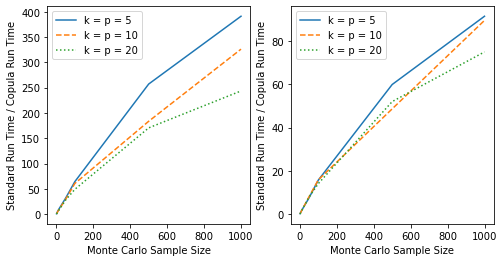

In [7]:
## Plot the computational speedup results
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

f1 = (res.k == 5) & (res.p == 5)
f2 = (res.k == 10) & (res.p == 10)
f3 = (res.k == 20) & (res.p == 20)
axes[0].plot(res['nsamps'][f1], res['speedup_total'][f1], color='tab:blue', label='k = p = 5')
axes[0].plot(res['nsamps'][f2], res['speedup_total'][f2], color='tab:orange', label='k = p = 10', linestyle='dashed')
axes[0].plot(res['nsamps'][f3], res['speedup_total'][f3], color='tab:green', label='k = p = 20', linestyle='dotted')
axes[0].set_ylabel('Standard Run Time / Copula Run Time')
axes[0].set_xlabel('Monte Carlo Sample Size')

axes[0].legend();

axes[1].plot(res['nsamps'][f1], res['speedup_interp'][f1], color='tab:blue', label='k = p = 5')
axes[1].plot(res['nsamps'][f2], res['speedup_interp'][f2], color='tab:orange', label='k = p = 10', linestyle='dashed')
axes[1].plot(res['nsamps'][f3], res['speedup_interp'][f3], color='tab:green', label='k = p = 20', linestyle='dotted')
axes[1].set_ylabel('Standard Run Time / Copula Run Time')
axes[1].set_xlabel('Monte Carlo Sample Size')


axes[1].legend();

### Distribution Comparison between Copula Forecasting and Standard Path Forecasting

- Sample from joint (path) forecast distribution using Copula Forecasting and standard sequential simulation
- Take two example runs $p = k = 20$ and $p = k = 5$, both with $nsamps = 10000$


In [8]:
def sim_study_path_forecasting(p, k, n=10000):

    a0 = np.ones(p)
    R0 = np.diag(0.1 * np.ones(p))

    pmod = pois_dglm(a0 = a0, R0 = R0,
                 ntrend = 1,
                 nregn = p - 1,
                 deltrend = .99,
                 delregn = .99,
                 interpolate=True)

    if p > 1:
        X = np.random.normal(0, 0.1, [k, p-1])
    else:
        X = None

    path_forecast = np.sort(pmod.forecast_path(k, X=X[:k].copy(), nsamps=n, copula=False).sum(axis=1))
    path_forecast_copula = np.sort(pmod.forecast_path(k, X=X[:k].copy(), nsamps=n, copula=True).sum(axis=1))
    
    corr = pmod.forecast_path(k, X=X[:k].copy(), nsamps=n, copula=True, return_cov=True)

    tmp = np.sqrt(corr.diagonal()).reshape(-1,1) @ np.sqrt(corr.diagonal()).reshape(-1,1).T

    corr = corr / tmp
    
    return path_forecast, path_forecast_copula, corr

In [9]:
path_forecast_20, path_forecast_copula_20, corr_20 = sim_study_path_forecasting(20, 20, 10000)

In [10]:
path_forecast_5, path_forecast_copula_5, corr_5 = sim_study_path_forecasting(5, 5, 10000)

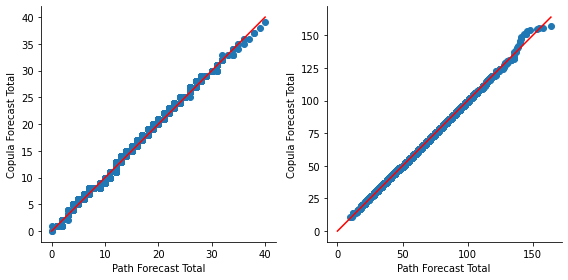

In [11]:
# Plot comparison of forecast distribution from the two methods

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].scatter(path_forecast_5, path_forecast_copula_5)
axes[0].plot(np.array([0, np.max(path_forecast_5)]), np.array([0, np.max(path_forecast_5)]), color='r')

axes[1].scatter(path_forecast_20, path_forecast_copula_20)
axes[1].plot(np.array([0, np.max(path_forecast_20)]), np.array([0, np.max(path_forecast_20)]), color='r')

axes[0] = ax_style(axes[0], xlabel='Path Forecast Total', ylabel='Copula Forecast Total')
axes[1] = ax_style(axes[1], xlabel='Path Forecast Total', ylabel='Copula Forecast Total')

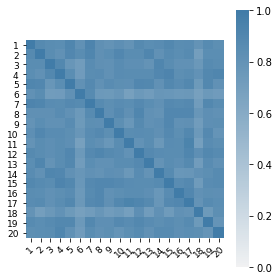

In [12]:
# Plot correlation matrix from simulation of k=20 forecast horizon

labels = [str(i) for i in range(1, 21)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
axes = sns.heatmap(corr_20, vmin=0, vmax=1, center = 0,
                 cmap=sns.diverging_palette(10, 240, as_cmap=True),
                cbar=True,
            square=True, ax=axes,
                   xticklabels=labels,
                   yticklabels=labels)
axes.set_xticklabels(labels = labels, rotation=45, size=9)
axes.set_yticklabels(labels = labels, rotation=0, size=9)
plt.tight_layout()